In [1]:
# Import required packages
import os
import sys
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')
#os.getcwd()

Mounted at /content/drive


In [3]:
path_to_utils='/content/drive/My Drive/NLP'
sys.path.append(path_to_utils)

In [4]:
os.chdir(path_to_utils)

print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1qJ8h8Q6C6t_FWn4R8pQeH813twKX9HgP/NLP


In [5]:
test_labels = pd.read_csv('test_w_text.csv')
test_data = pd.read_csv('test_tweets.csv')

train_labels = pd.read_csv('obtained_train.csv')
train_data = pd.read_csv('train_tweets.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (23,63,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
train_labels.columns, test_labels.columns

(Index(['label', 'id', 'text'], dtype='object'),
 Index(['label', 'id', 'text'], dtype='object'))

In [7]:
metadata=['id', 'author_id', 'created_at', 'text', 'source',
        'public_metrics.like_count', 'public_metrics.quote_count',
        'public_metrics.reply_count', 'public_metrics.retweet_count',
        'author.id', 'author.created_at',
        'author.username', 'author.name', 'author.description',
        'author.location', 'author.public_metrics.followers_count',
        'author.public_metrics.following_count',
        'author.public_metrics.listed_count',
        'author.public_metrics.tweet_count', 'author.verified']

In [8]:
test_data=test_data[metadata]
test_data=pd.merge(test_labels[['id','label']],test_data, on='id', how='left')

train_data=train_data[metadata]
train_data=pd.merge(train_labels[['id','label']],train_data, on='id', how='left')

test_data.columns,train_data.columns

(Index(['id', 'label', 'author_id', 'created_at', 'text', 'source',
        'public_metrics.like_count', 'public_metrics.quote_count',
        'public_metrics.reply_count', 'public_metrics.retweet_count',
        'author.id', 'author.created_at', 'author.username', 'author.name',
        'author.description', 'author.location',
        'author.public_metrics.followers_count',
        'author.public_metrics.following_count',
        'author.public_metrics.listed_count',
        'author.public_metrics.tweet_count', 'author.verified'],
       dtype='object'),
 Index(['id', 'label', 'author_id', 'created_at', 'text', 'source',
        'public_metrics.like_count', 'public_metrics.quote_count',
        'public_metrics.reply_count', 'public_metrics.retweet_count',
        'author.id', 'author.created_at', 'author.username', 'author.name',
        'author.description', 'author.location',
        'author.public_metrics.followers_count',
        'author.public_metrics.following_count',
        '

In [9]:
len(test_data), len(train_data)

(1281, 26655)

In [10]:
def datatime(test_data):
  test_data['Date'] = pd.to_datetime(test_data['created_at']).dt.date
  test_data['Time'] = pd.to_datetime(test_data['created_at']).dt.time
  test_data['Day_of_Week']=pd.to_datetime(test_data['created_at']).dt.day_name()
  
  return test_data

datatime(test_data)
datatime(train_data)

,id,label,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,Date,Time,Day_of_Week
0,1081277365785976832,neutral,2.270364e+07,2019-01-04T19:53:07.000Z,Happy 2019. There are a lot of things going on...,Twitter Web Client,8762.0,601.0,10305.0,1843.0,...,"Emmy-award-winning broadcast journalist, gradu...",NaN,5321287.0,149.0,14638.0,4493.0,True,2019-01-04,19:53:07,Friday
1,1081465965601271808,neutral,2.205939e+07,2019-01-05T08:22:33.000Z,"As elected CEO of KDSG, I take ultimate respon...",Twitter for iPad,8574.0,262.0,2531.0,1533.0,...,"Governor of Kaduna State, Nigeria. Founding Me...","Kaduna, Nigeria",2207514.0,929.0,1785.0,66307.0,True,2019-01-05,08:22:33,Saturday
2,1084152409255866368,neutral,1.640968e+07,2019-01-12T18:17:31.000Z,Can you believe that this album was released 2...,Twitter Web Client,104926.0,5111.0,5106.0,22138.0,...,#HoldMeCloser with @EltonOfficial out now 🌹🚀,"Los Angeles, CA",56142060.0,360453.0,108592.0,5641.0,True,2019-01-12,18:17:31,Saturday
3,1085493525335166976,neutral,8.207058e+17,2019-01-16T11:06:38.000Z,Before Alexandria was known around the world a...,Twitter Web Client,4168.0,314.0,1089.0,1429.0,...,"Building The Squad. We helped elect @AOC, @Jam...",NaN,364347.0,979.0,2191.0,19683.0,True,2019-01-16,11:06:38,Wednesday
4,1087036824042856448,positive,4.629630e+07,2019-01-20T17:19:09.000Z,.@AOC is only speaking facts. This is so far b...,Twitter for iPhone,2170.0,1642.0,9444.0,639.0,...,I am simply here to help save the world. Nothi...,#SumOfMyMusic,1273238.0,410.0,1045.0,14267.0,True,2019-01-20,17:19:09,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26650,1233463115611824128,neutral,2.801780e+09,2020-02-28T18:44:58.000Z,"50 years ago today, NYC Transit PD Patrolman M...",Twitter for iPhone,180.0,2.0,20.0,27.0,...,"The official Twitter of Keechant Sewell, Polic...",New York City,126467.0,415.0,681.0,7530.0,True,2020-02-28,18:44:58,Friday
26651,1233485144247459840,negative,3.107464e+08,2020-02-28T20:12:30.000Z,For decades after the link between smoking and...,Twitter Web App,525.0,2.0,28.0,120.0,...,Born Andrew Scott. Journalist and professional...,London,132067.0,1925.0,698.0,228195.0,True,2020-02-28,20:12:30,Friday
26652,1233512637276807168,negative,7.852330e+07,2020-02-28T22:01:44.000Z,“Smoking cigarettes kills more Americans than ...,Twitter for iPhone,5726.0,105.0,582.0,1297.0,...,This is the ONLY verified Twitter account for ...,NaN,2623563.0,4461.0,8661.0,35507.0,True,2020-02-28,22:01:44,Friday
26653,1233514593479249921,neutral,7.852330e+07,2020-02-28T22:09:31.000Z,Glad you showed this. Within a year of that pi...,Twitter for iPhone,23015.0,317.0,1728.0,3845.0,...,This is the ONLY verified Twitter account for ...,NaN,2623559.0,4461.0,8661.0,35507.0,True,2020-02-28,22:09:31,Friday


In [11]:
test_data[test_data['Time'].isnull()]

,id,label,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,Date,Time,Day_of_Week


In [12]:
test_data.dropna(subset=['created_at'])

#df[pd.notnull(df['EPS'])]

,id,label,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.description,author.location,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,Date,Time,Day_of_Week
0,1222226229446750214,negative,705706292,2020-01-28T18:33:35.000Z,Deputy White House counsel Pat Philbin on the ...,Twitter Web Client,161,83,196,48,...,@WSJ investigative reporter. Previously covere...,New York,104645,1979,2123,22428,True,2020-01-28,18:33:35,Tuesday
1,1236289649737371648,negative,130193367,2020-03-07T13:56:36.000Z,Panic buying and stockpiling of toilet roll co...,Twitter for iPhone,13151,11965,6626,4459,...,"News Editor, ITV Meridian. Views my own.",NaN,5119,2915,64,26626,False,2020-03-07,13:56:36,Saturday
2,1222258314857172993,negative,20094409,2020-01-28T20:41:05.000Z,"It’s Super Bowl week, and Trump is using a pre...",Twitter for iPhone,361,1,30,84,...,"@UMichLaw prof; former US Atty, EDMI, author o...","Ann Arbor, MI",604148,1334,3854,11420,True,2020-01-28,20:41:05,Tuesday
3,1236432648374857728,negative,15115280,2020-03-07T23:24:49.000Z,Turns out Donald Trump was potentially exposed...,Twitter for iPhone,8284,163,704,1511,...,Political analysis ahead of the curve.,"Los Angeles, CA",496051,109806,3617,199130,True,2020-03-07,23:24:49,Saturday
4,1233925225697488901,positive,1304192136,2020-03-01T01:21:13.000Z,Had a totally surreal author moment at B&amp;N...,Twitter for iPhone,342,0,33,18,...,"YA author, history nerd, dog lover, & cookie a...",New Jersey,3080,1282,53,6453,False,2020-03-01,01:21:13,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1236253264615804928,positive,2891898418,2020-03-07T11:32:01.000Z,Mexican primetime television levelled up in 20...,Sprout Social,810,22,151,474,...,Nominations open 28.09.22! \n\nCelebrating ind...,"London, UK",49139,4966,266,19904,True,2020-03-07,11:32:01,Saturday
1277,1234218004923043841,positive,35026720,2020-03-01T20:44:37.000Z,Those moments of season and spirit when even t...,Twitter for iPhone,5231,55,205,455,...,NaN,NaN,526934,320,952,9574,True,2020-03-01,20:44:37,Sunday
1278,1224379446997798912,positive,846159595940786176,2020-02-03T17:09:42.000Z,Happy Birthday to me....\nCommitted! #GatorGan...,Twitter for iPhone,2224,113,63,444,...,Florida.,"Illinois, USA",3388,133,13,2873,False,2020-02-03,17:09:42,Monday
1279,1221756922031955968,neutral,241983890,2020-01-27T11:28:44.000Z,MORE: Men divide 56-39% in favor of Pres. Trum...,Twitter for iPad,102,32,23,44,...,"Former DOD, VA, and FEMA senior official tweet...",NaN,13578,8,577,745407,False,2020-01-27,11:28:44,Monday


In [13]:
data=pd.to_datetime(test_data['Time'], format="%H:%M:%S") 

data_pos= pd.to_datetime(test_data[test_data.label=='positive']['Time'], format="%H:%M:%S") 
data_neut= pd.to_datetime(test_data[test_data.label=='neutral']['Time'], format="%H:%M:%S") 
data_neg= pd.to_datetime(test_data[test_data.label=='negative']['Time'], format="%H:%M:%S") 


In [ ]:
test_data['fraction_24_hrs'] = (dates - dates.dt.floor('D')) / pd.Timedelta(24, 'H')

AttributeError: ignored

In [ ]:
plt.hist([data_pos['Time'],data_neut['Time']],bins=24, range=(0,24), stacked=True, color = ['r','g'])

KeyError: ignored

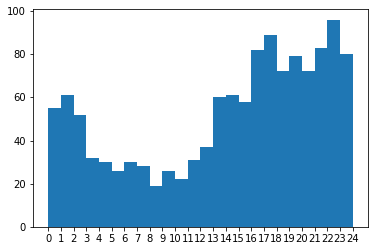

In [14]:
hour_list = [t.hour for t in data]

hour_list_pos = [t.hour for t in data_pos]
hour_list_neut = [t.hour for t in data_neut]
hour_list_neg = [t.hour for t in data_neg]
bins = np.arange(0,25)

numbers=[x for x in range(0,25)]
labels=map(lambda x: str(x), numbers)

plt.xticks(numbers, labels)
plt.hist(hour_list,bins)

plt.show()

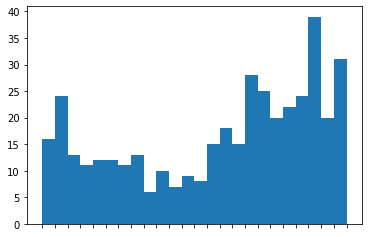

In [15]:
plt.xticks(numbers, labels)
plt.hist(hour_list_pos,bins)

plt.show()

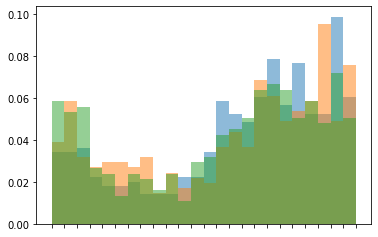

In [16]:
plt.xticks(numbers, labels)
plt.hist(hour_list_neg,bins, alpha=0.5, density=True) #BLUE 
plt.hist(hour_list_pos,bins, alpha=0.5, density=True) #ORANGE
plt.hist(hour_list_neut,bins, alpha=0.5, density=True) #GREEN
#plt.legend()
plt.show()

Text(0.5, 1.0, 'Subplot 4: Neutral Labeled')

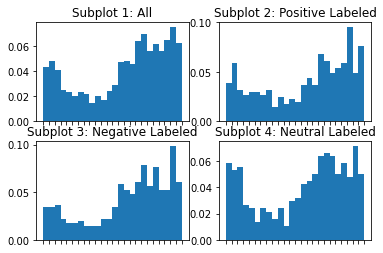

In [17]:
plt.subplot(2,2,1)
plt.xticks(numbers, labels)
plt.hist(hour_list,bins,  density=True)
plt.title('Subplot 1: All')
#plt.show()

plt.subplot(2,2,2)
plt.xticks(numbers, labels)
plt.hist(hour_list_pos,bins,  density=True)
plt.title('Subplot 2: Positive Labeled')

plt.subplot(2,2,3)
plt.xticks(numbers, labels)
plt.hist(hour_list_neg,bins,  density=True)
plt.title('Subplot 3: Negative Labeled')

plt.subplot(2,2,4)
plt.xticks(numbers, labels)
plt.hist(hour_list_neut,bins,  density=True)
plt.title('Subplot 4: Neutral Labeled')

In [18]:
test_data.value_counts(["label", "source"])

label     source            
negative  Twitter for iPhone    204
positive  Twitter for iPhone    190
neutral   Twitter for iPhone    158
negative  Twitter Web App       127
neutral   Twitter Web App       103
                               ... 
          Twitter Ads             1
          Tweetbot for Mac        1
          Echobox                 1
          Sprout Social           1
          Sprinklr                1
Length: 61, dtype: int64

In [19]:
pd.crosstab(test_data.label,test_data.source, normalize='index')


source,Brandwatch,Buffer,Business Insider Login,Chorus publishing platform,Echobox,Echofon,Emplifi,GoNintendo Tweeter,Hootsuite Inc.,LinkedIn,...,Twitter Ads,Twitter Media Studio,Twitter Media Studio - LiveCut,Twitter VIT App for iOS,Twitter Web App,Twitter Web Client,Twitter for Advertisers.,Twitter for Android,Twitter for iPad,Twitter for iPhone
label,,,,,,,,,,,,,,,,,,,,,
negative,0.000000,0.006048,0.002016,0.002016,0.002016,0.00000,0.000000,0.000000,0.010081,0.000000,...,0.00000,0.014113,0.002016,0.00000,0.256048,0.042339,0.000000,0.088710,0.032258,0.411290
neutral,0.000000,0.007979,0.000000,0.000000,0.002660,0.00266,0.000000,0.000000,0.000000,0.000000,...,0.00266,0.026596,0.000000,0.00266,0.273936,0.023936,0.000000,0.130319,0.018617,0.420213
positive,0.002445,0.002445,0.000000,0.000000,0.000000,0.00000,0.002445,0.002445,0.012225,0.002445,...,0.00000,0.051345,0.002445,0.00000,0.229829,0.019560,0.002445,0.132029,0.014670,0.464548


In [20]:
test_data['Year'] = pd.DatetimeIndex(test_data['Date']).year
test_data['Month'] = pd.DatetimeIndex(test_data['Date']).month
test_data['Day'] = pd.DatetimeIndex(test_data['Date']).day

In [21]:
test_data

,id,label,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,Date,Time,Day_of_Week,Year,Month,Day
0,1222226229446750214,negative,705706292,2020-01-28T18:33:35.000Z,Deputy White House counsel Pat Philbin on the ...,Twitter Web Client,161,83,196,48,...,1979,2123,22428,True,2020-01-28,18:33:35,Tuesday,2020,1,28
1,1236289649737371648,negative,130193367,2020-03-07T13:56:36.000Z,Panic buying and stockpiling of toilet roll co...,Twitter for iPhone,13151,11965,6626,4459,...,2915,64,26626,False,2020-03-07,13:56:36,Saturday,2020,3,7
2,1222258314857172993,negative,20094409,2020-01-28T20:41:05.000Z,"It’s Super Bowl week, and Trump is using a pre...",Twitter for iPhone,361,1,30,84,...,1334,3854,11420,True,2020-01-28,20:41:05,Tuesday,2020,1,28
3,1236432648374857728,negative,15115280,2020-03-07T23:24:49.000Z,Turns out Donald Trump was potentially exposed...,Twitter for iPhone,8284,163,704,1511,...,109806,3617,199130,True,2020-03-07,23:24:49,Saturday,2020,3,7
4,1233925225697488901,positive,1304192136,2020-03-01T01:21:13.000Z,Had a totally surreal author moment at B&amp;N...,Twitter for iPhone,342,0,33,18,...,1282,53,6453,False,2020-03-01,01:21:13,Sunday,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1236253264615804928,positive,2891898418,2020-03-07T11:32:01.000Z,Mexican primetime television levelled up in 20...,Sprout Social,810,22,151,474,...,4966,266,19904,True,2020-03-07,11:32:01,Saturday,2020,3,7
1277,1234218004923043841,positive,35026720,2020-03-01T20:44:37.000Z,Those moments of season and spirit when even t...,Twitter for iPhone,5231,55,205,455,...,320,952,9574,True,2020-03-01,20:44:37,Sunday,2020,3,1
1278,1224379446997798912,positive,846159595940786176,2020-02-03T17:09:42.000Z,Happy Birthday to me....\nCommitted! #GatorGan...,Twitter for iPhone,2224,113,63,444,...,133,13,2873,False,2020-02-03,17:09:42,Monday,2020,2,3
1279,1221756922031955968,neutral,241983890,2020-01-27T11:28:44.000Z,MORE: Men divide 56-39% in favor of Pres. Trum...,Twitter for iPad,102,32,23,44,...,8,577,745407,False,2020-01-27,11:28:44,Monday,2020,1,27


In [22]:
test_data['Day'].value_counts()

28    154
1     122
7     120
29     98
2      86
8      79
3      74
31     62
6      59
10     55
9      55
4      41
27     40
26     38
11     35
12     35
13     27
30     22
25     18
5      18
24     12
16     10
23      8
14      7
15      5
22      1
Name: Day, dtype: int64

In [23]:
test_data['Day_of_Week'].value_counts()

Saturday     266
Tuesday      214
Friday       182
Sunday       179
Monday       172
Wednesday    166
Thursday     102
Name: Day_of_Week, dtype: int64

In [24]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
        'Friday', 'Saturday', 'Sunday']

In [25]:
dfp=pd.crosstab(test_data.label,test_data.Day_of_Week, normalize='index')
dfp_inv=pd.crosstab(test_data.Day_of_Week,test_data.label, normalize='index')

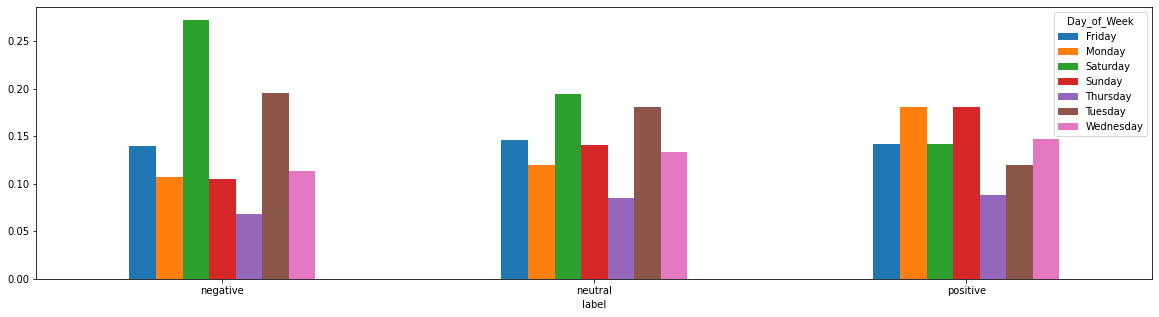

In [26]:

dfp.plot(kind='bar', figsize=(20, 5), rot=0)
plt.show()

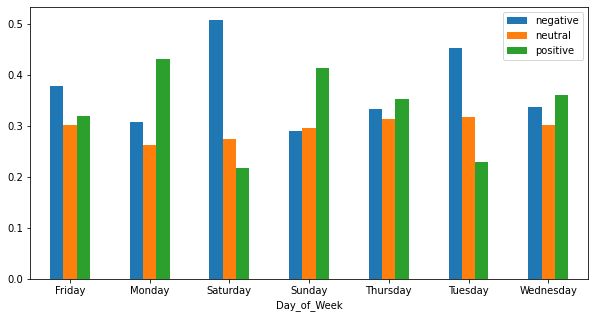

In [27]:
dfp_inv.plot(kind='bar', figsize=(10, 5), rot=0)
plt.legend()
plt.show()

In [29]:
dfp_inv

label,negative,neutral,positive
Day_of_Week,,,
Friday,0.379121,0.302198,0.318681
Monday,0.308140,0.261628,0.430233
Saturday,0.507519,0.274436,0.218045
Sunday,0.290503,0.296089,0.413408
Thursday,0.333333,0.313725,0.352941
Tuesday,0.453271,0.317757,0.228972
Wednesday,0.337349,0.301205,0.361446


In [32]:
pd.crosstab(test_data.Day_of_Week,test_data.label)

label,negative,neutral,positive
Day_of_Week,,,
Friday,69,55,58
Monday,53,45,74
Saturday,135,73,58
Sunday,52,53,74
Thursday,34,32,36
Tuesday,97,68,49
Wednesday,56,50,60


In [33]:
test_data

,id,label,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.public_metrics.following_count,author.public_metrics.listed_count,author.public_metrics.tweet_count,author.verified,Date,Time,Day_of_Week,Year,Month,Day
0,1222226229446750214,negative,705706292,2020-01-28T18:33:35.000Z,Deputy White House counsel Pat Philbin on the ...,Twitter Web Client,161,83,196,48,...,1979,2123,22428,True,2020-01-28,18:33:35,Tuesday,2020,1,28
1,1236289649737371648,negative,130193367,2020-03-07T13:56:36.000Z,Panic buying and stockpiling of toilet roll co...,Twitter for iPhone,13151,11965,6626,4459,...,2915,64,26626,False,2020-03-07,13:56:36,Saturday,2020,3,7
2,1222258314857172993,negative,20094409,2020-01-28T20:41:05.000Z,"It’s Super Bowl week, and Trump is using a pre...",Twitter for iPhone,361,1,30,84,...,1334,3854,11420,True,2020-01-28,20:41:05,Tuesday,2020,1,28
3,1236432648374857728,negative,15115280,2020-03-07T23:24:49.000Z,Turns out Donald Trump was potentially exposed...,Twitter for iPhone,8284,163,704,1511,...,109806,3617,199130,True,2020-03-07,23:24:49,Saturday,2020,3,7
4,1233925225697488901,positive,1304192136,2020-03-01T01:21:13.000Z,Had a totally surreal author moment at B&amp;N...,Twitter for iPhone,342,0,33,18,...,1282,53,6453,False,2020-03-01,01:21:13,Sunday,2020,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1236253264615804928,positive,2891898418,2020-03-07T11:32:01.000Z,Mexican primetime television levelled up in 20...,Sprout Social,810,22,151,474,...,4966,266,19904,True,2020-03-07,11:32:01,Saturday,2020,3,7
1277,1234218004923043841,positive,35026720,2020-03-01T20:44:37.000Z,Those moments of season and spirit when even t...,Twitter for iPhone,5231,55,205,455,...,320,952,9574,True,2020-03-01,20:44:37,Sunday,2020,3,1
1278,1224379446997798912,positive,846159595940786176,2020-02-03T17:09:42.000Z,Happy Birthday to me....\nCommitted! #GatorGan...,Twitter for iPhone,2224,113,63,444,...,133,13,2873,False,2020-02-03,17:09:42,Monday,2020,2,3
1279,1221756922031955968,neutral,241983890,2020-01-27T11:28:44.000Z,MORE: Men divide 56-39% in favor of Pres. Trum...,Twitter for iPad,102,32,23,44,...,8,577,745407,False,2020-01-27,11:28:44,Monday,2020,1,27


In [34]:
test_data['public_metrics.like_count'].max()
test_data['public_metrics.like_count'].min()

14

In [35]:
pos= test_data[test_data.label=='positive']
neut= test_data[test_data.label=='neutral'] 
neg= test_data[test_data.label=='negative']

In [36]:
def hist_by_met(metric, cut_off):

  print('pos max: ',pos[metric].max(),'\npos min: ',pos[metric].min(),'\npos avg: ',pos[metric].mean())
  print('=================================================')

  print('neg max: ',neg[metric].max(),'\nneg min: ',neg[metric].min(),'\nneg avg: ',neg[metric].mean())
  print('=================================================')

  print('neut max: ',neut[metric].max(),'\nneut min: ',neut[metric].min(),'\nneut avg',neut[metric].mean())
  print('=================================================')

  plt.subplot(1,3,1)
  plt.hist(pos[pos[metric]<cut_off][metric])
  plt.title('Positive Labeled Tweet')
  #plt.show()

  plt.subplot(1,3,2)
  plt.hist(neg[neg[metric]<cut_off][metric])
  plt.title('Negative Labeled Tweet')

  plt.subplot(1,3,3)
  plt.hist(neut[neut[metric]<cut_off][metric])
  plt.title('Subplot 3: Neutral Labeled')





pos max:  781300 
pos min:  41 
pos avg:  12090.863080684596
neg max:  363942 
neg min:  14 
neg avg:  6365.002016129032
neut max:  569616 
neut min:  28 
neut avg 8629.59840425532


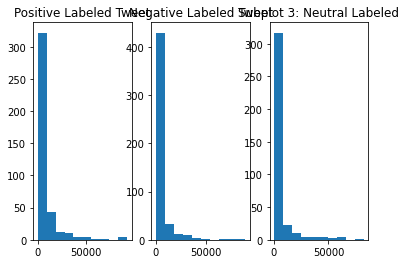

In [37]:
hist_by_met('public_metrics.like_count', 100000)

In [ ]:
df_label=[pos, neg, neut]


for df in df_label:
  df['like_rep_ratio']=df['public_metrics.like_count']/df['public_metrics.reply_count'] 
  df['like_rtw_ratio']=df['public_metrics.like_count']/df['public_metrics.retweet_count'] 
  df['follow_ratio']=df['author.public_metrics.following_count']/df['author.public_metrics.followers_count']


<ipython-input-162-4dd6e006f8fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['like_rep_ratio']=df['public_metrics.like_count']/df['public_metrics.reply_count']
<ipython-input-162-4dd6e006f8fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['like_rtw_ratio']=df['public_metrics.like_count']/df['public_metrics.retweet_count']
<ipython-input-162-4dd6e006f8fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [ ]:
pos

,label,id,author_id,created_at,text,source,public_metrics.like_count,public_metrics.quote_count,public_metrics.reply_count,public_metrics.retweet_count,...,author.public_metrics.tweet_count,author.verified,Date,Time,Year,Month,Day,Day_of_Week,like_rep_ratio,like_rtw_ratio
2,positive,1237489705090002944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,positive,1233925225697488901,1.304192e+09,2020-03-01T01:21:13.000Z,Had a totally surreal author moment at B&amp;N...,Twitter for iPhone,342.0,0.0,33.0,18.0,...,6453.0,False,2020-03-01,01:21:13,2020.0,3.0,1.0,Sunday,10.363636,19.000000
11,positive,1236139967241281536,2.596120e+08,2020-03-07T04:01:49.000Z,The 87-year old patient stayed in Wu Han hospi...,Twitter for iPhone,11694.0,201.0,53.0,6841.0,...,4013.0,False,2020-03-07,04:01:49,2020.0,3.0,7.0,Saturday,220.641509,1.709399
21,positive,1234588287269920769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
25,positive,1232518902388809728,1.190458e+18,2020-02-26T04:13:00.000Z,I feel like the most powerful witch to have ev...,Twitter Web App,569.0,5.0,25.0,177.0,...,28970.0,False,2020-02-26,04:13:00,2020.0,2.0,26.0,Wednesday,22.760000,3.214689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,positive,1223928872527454208,1.020396e+18,2020-02-02T11:19:17.000Z,Happy Birthday to me🍾🎉🥂❤😊\n#21st 🎊🎉 https://t....,Twitter for Android,412.0,3.0,25.0,5.0,...,2831.0,False,2020-02-02,11:19:17,2020.0,2.0,2.0,Sunday,16.480000,82.400000
1511,positive,1236253264615804928,2.891898e+09,2020-03-07T11:32:01.000Z,Mexican primetime television levelled up in 20...,Sprout Social,810.0,22.0,151.0,474.0,...,19904.0,True,2020-03-07,11:32:01,2020.0,3.0,7.0,Saturday,5.364238,1.708861
1512,positive,1234218004923043841,3.502672e+07,2020-03-01T20:44:37.000Z,Those moments of season and spirit when even t...,Twitter for iPhone,5231.0,55.0,205.0,455.0,...,9574.0,True,2020-03-01,20:44:37,2020.0,3.0,1.0,Sunday,25.517073,11.496703
1513,positive,1224379446997798912,8.461596e+17,2020-02-03T17:09:42.000Z,Happy Birthday to me....\nCommitted! #GatorGan...,Twitter for iPhone,2224.0,113.0,63.0,444.0,...,2873.0,False,2020-02-03,17:09:42,2020.0,2.0,3.0,Monday,35.301587,5.009009


pos max:  831.940594059406 
pos min:  0.711304347826087 
pos avg:  53.67244417306932
neg max:  375.97314049586777 
neg min:  0.1085972850678733 
neg avg:  19.425405757032795
neut max:  1289.063829787234 
neut min:  0.11228070175438597 
neut avg 46.277432067015795


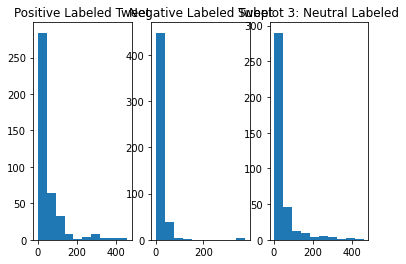

In [ ]:
hist_by_met('like_rep_ratio', 500)

pos max:  inf 
pos min:  0.5555555555555556 
pos avg:  inf
neg max:  69.0625 
neg min:  0.4863013698630137 
neg avg:  3.667279302252149
neut max:  84.75 
neut min:  0.5672268907563025 
neut avg 5.972849634844087


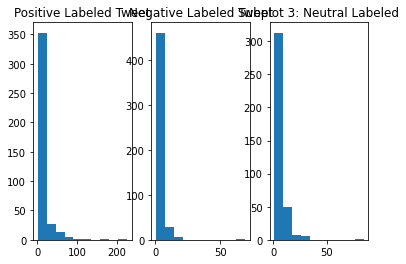

In [ ]:
hist_by_met('like_rtw_ratio', 500)

pos max:  10705 
pos min:  20 
pos avg:  244.3398533007335
neg max:  21506 
neg min:  21 
neg avg:  456.008064516129
neut max:  6095 
neut min:  19 
neut avg 206.9281914893617


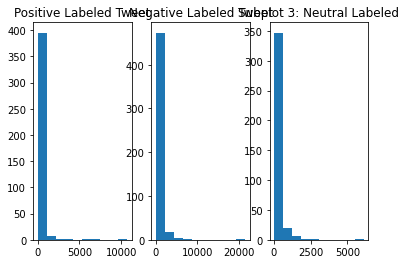

In [38]:
hist_by_met('public_metrics.reply_count',100000)

pos max:  180668.0 
pos min:  0.0 
pos avg:  2704.7017114914424
neg max:  180289.0 
neg min:  3.0 
neg avg:  2053.3407258064517
neut max:  77862.0 
neut min:  2.0 
neut avg 1709.5053191489362


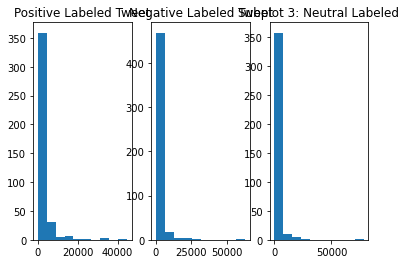

In [ ]:
hist_by_met('public_metrics.retweet_count',100000)

In [ ]:
test_data['author.location'].unique()

array(['New York', nan, 'Ann Arbor, MI', 'Los Angeles, CA', 'New Jersey',
       'Washington DC', 'Washington, DC', '12, Tughlak Lane, New Delhi',
       'USA', 'freeridge', 'Auckland, New Zealand',
       'Washington, DC & New York, NY', 'United States',
       'Washington, DC & New York City', 'London, UK', 'Washington, DC ',
       'Washington, D.C.', 'Texas, USA', 'Tufnell Park', 'Oregon',
       'Balmung', 'Washington, DC I Orlando, FL',
       'Lewis.goodall@global.com', 'Florida, Man.',
       'Living on stolen Yugambeh land', 'Lagos, Nigeria', 'Los Angeles',
       'Lost in Cheshire', 'In Your Head ', 'Boston, MA', 'New York, USA',
       'Chicago, IL', 'long island', 'Worldwide', 'they/them',
       'Philly USA', '🤍 원호 위니 오호호 호떡 몬스타엑스 몬베베 🤍', 'City of Angels',
       'Allahabad/New Delhi', 'Global', 'Hartfield, England',
       'The Criminal Courts', 'Columbus, OH', 'New York City',
       'Hong Kong', 'Somerset', 'Washington, DC 🇺🇸🇰🇷', 'Texas',
       'New York City jr3@nyu.e

pos max:  91789634.0 
pos min:  43.0 
pos avg:  1501588.6821515893
neg max:  64093297.0 
neg min:  13.0 
neg avg:  1246012.9717741935
neut max:  45344942.0 
neut min:  18.0 
neut avg 789291.0558510638


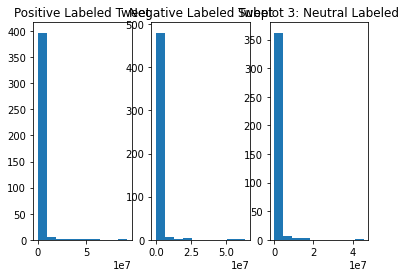

In [ ]:
hist_by_met('author.public_metrics.followers_count',100000000)

pos max:  232272.0 
pos min:  0.0 
pos avg:  5142.960880195599
neg max:  427010.0 
neg min:  1.0 
neg avg:  9814.133064516129
neut max:  389169.0 
neut min:  0.0 
neut avg 7429.920212765957


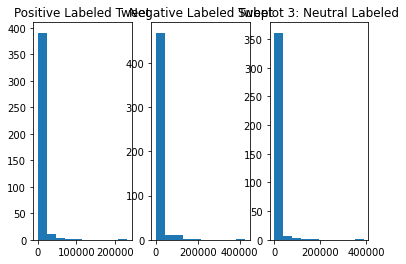

In [ ]:
hist_by_met('author.public_metrics.following_count',100000000)

pos max:  2.4444444444444446 
pos min:  0.0 
pos avg:  0.17428953749973397
neg max:  5.814814814814815 
neg min:  3.972582506764712e-07 
neg avg:  0.18572026239222786
neut max:  10.222222222222221 
neut min:  0.0 
neut avg 0.2920185519841078


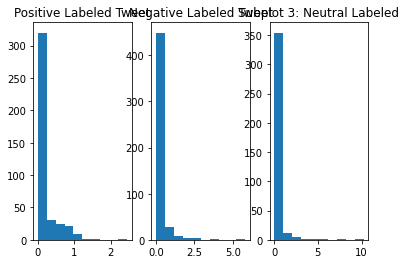

In [ ]:
hist_by_met('follow_ratio',10000000)